In [12]:
from __future__ import annotations

import os, gc, ast, random, inspect
from pathlib import Path
from typing import Dict, List, Tuple, Callable

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm, trange


In [13]:
POOL_SIZE     = 20_000
MIN_PER_POINT = 2_000
N_POINTS      = 200
HEAVY_MAX_N   = 2_000
DADAPY_RANGE_K = 32


## Correct

In [14]:
from __future__ import annotations

from pathlib import Path

# -------------------- data / model --------------------
CSV_PATH      = "en_ewt-ud-train_sentences.csv"
BASELINE      = "openai-community/gpt2"
WORD_REP_MODE = "last"   # {"first","last","mean"}
EXCLUDE_POS   = {"X","SYM","INTJ","PART"}

# Choose ONE layer only.
# For BERT-base / GPT-2, hidden_states[0] is embeddings, hidden_states[12] is last layer.
LAYER_IDX = 12

# -------------------- points for correlation --------------------
# Embed one pool once, then create many "points" by subsampling it.
POOL_SIZE      = 20_000     # number of word tokens to embed once (>= MIN_PER_POINT)
N_POINTS       = 200        # number of correlation points you want
MIN_PER_POINT  = 2_000      # subsample size used to compute each metric point

# -------------------- embedding performance --------------------
BATCH_SIZE_SENT = 16       # sentence batch size (embedding)
RAND_SEED       = 42

# -------------------- heavy metrics (kNN-based) --------------------
# If you keep MIN_PER_POINT=5000, you can also cap kNN methods here (usually keep = 5000).
HEAVY_MAX_N     = 2000
DADAPY_RANGE_K  = 32       # GRIDE range_max; 32 or 64 typical

# Duplicate-row handling for kNN methods
DUP_JITTER_REL  = 1e-6     # jitter scale relative to global std

# -------------------- outputs --------------------
OUT_DIR = Path("metric_corr_layer12_gpt")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [15]:
import os, gc, ast, random, inspect
from typing import Dict, Callable, Optional

import numpy as np
import pandas as pd

import torch
from transformers import AutoTokenizer, AutoModel

from tqdm.auto import tqdm  # works well in notebooks; also try tqdm.notebook if you prefer :contentReference[oaicite:2]{index=2}

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr  # Spearman rho + p-value :contentReference[oaicite:3]{index=3}

# multiple testing correction (optional)
HAS_STATSMODELS = False
try:
    from statsmodels.stats.multitest import multipletests
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False

# Optional deps for some metrics
HAS_DADAPY = False
try:
    from dadapy import Data
    HAS_DADAPY = True
except Exception:
    HAS_DADAPY = False

HAS_SKDIM = False
try:
    from skdim.id import MOM, TLE, CorrInt, FisherS, lPCA, MLE, ESS, MADA
    HAS_SKDIM = True
except Exception:
    HAS_SKDIM = False


# Repro
os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 120


device: cuda


In [16]:
EPS = 1e-12

def _to_list(x):
    if isinstance(x, str) and x.startswith("["):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

def load_sentences_and_words(csv_path: str, exclude_pos: Optional[set[str]] = None):
    """
    Loads sentences (tokens+pos) and builds a (sentence_id, word_id) table excluding POS if requested.
    Keeps only needed columns to reduce RAM.
    """
    df = pd.read_csv(csv_path, usecols=["sentence_id", "tokens", "pos"])
    df["sentence_id"] = df["sentence_id"].astype(str)
    df["tokens"] = df["tokens"].apply(_to_list)
    df["pos"]    = df["pos"].apply(_to_list)

    rows = []
    for sid, toks, poss in df[["sentence_id","tokens","pos"]].itertuples(index=False):
        for wid, p in enumerate(poss):
            if exclude_pos is not None and p in exclude_pos:
                continue
            rows.append((sid, int(wid)))

    all_words = pd.DataFrame(rows, columns=["sentence_id","word_id"])
    df_sent = df.drop_duplicates("sentence_id").set_index("sentence_id", drop=True)

    return df_sent, all_words


def sample_pool_words(all_words: pd.DataFrame, pool_size: int, seed: int = 42) -> pd.DataFrame:
    if pool_size > len(all_words):
        raise ValueError(f"POOL_SIZE={pool_size} > available words={len(all_words)}")
    return all_words.sample(pool_size, replace=False, random_state=seed).reset_index(drop=True)


def _prep_for_knn(
    X: np.ndarray,
    cap: Optional[int],
    rng: np.random.Generator,
    jitter_rel: float = 1e-6
) -> np.ndarray:
    """
    For kNN estimators that complain about duplicates:
      1) float32 contiguous
      2) drop exact duplicate rows
      3) optional subsample to cap
      4) add tiny jitter (scaled by std) to break remaining ties in float32
    """
    X = np.ascontiguousarray(X, dtype=np.float32)

    # drop exact duplicates
    try:
        X = np.unique(X, axis=0)
    except Exception:
        pass

    # cap size
    if cap is not None and X.shape[0] > cap:
        idx = rng.choice(X.shape[0], cap, replace=False)
        X = X[idx]

    # jitter
    std = float(X.std()) or 1.0
    eps = jitter_rel * std
    X = X + rng.normal(0.0, eps, size=X.shape).astype(np.float32)

    return X


In [17]:
def build_tokenizer_and_model(model_name: str):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=True)
    tok.pad_token = tok.eos_token

    model = AutoModel.from_pretrained(model_name, output_hidden_states=True).eval().to(device)

    # Optional speed on GPU; still convert outputs to float32 for metric stability
    if device.type == "cuda":
        model.half()

    return tok, model


def embed_words_one_layer(
    df_sent: pd.DataFrame,               # indexed by sentence_id
    words_df: pd.DataFrame,              # columns: sentence_id, word_id
    tokenizer,
    model,
    layer_idx: int,
    word_rep_mode: str,
    batch_size_sent: int,
) -> np.ndarray:
    """
    Returns X of shape (N, D) for the selected layer only.
    Processes only sentences that contain sampled words.
    """
    words_df = words_df.copy()
    words_df["sentence_id"] = words_df["sentence_id"].astype(str)

    # sentence -> list of (global_index_in_words_df, word_id)
    by_sid = {}
    for gidx, (sid, wid) in enumerate(words_df[["sentence_id","word_id"]].itertuples(index=False)):
        by_sid.setdefault(sid, []).append((gidx, int(wid)))

    sids = list(by_sid.keys())

    # keep sentence order aligned to sids
    # df_sent is indexed by sentence_id
    df_sel = df_sent.loc[sids]

    # tokenizer kwargs
    enc_kwargs = dict(is_split_into_words=True, return_tensors="pt", padding=True, truncation=True)
    if "add_prefix_space" in inspect.signature(tokenizer.__call__).parameters:
        enc_kwargs["add_prefix_space"] = True

    D = getattr(model.config, "hidden_size", None) or getattr(model.config, "n_embd", None)
    if D is None:
        raise ValueError("Could not infer hidden size from model config.")

    N = len(words_df)
    reps = np.zeros((N, D), dtype=np.float32)
    filled = np.zeros(N, dtype=bool)

    with torch.inference_mode():
        for start in tqdm(range(0, len(sids), batch_size_sent), desc="Embedding sentences", leave=False):
            batch_ids = sids[start:start+batch_size_sent]
            batch_tokens = df_sel.loc[batch_ids, "tokens"].tolist()

            enc = tokenizer(batch_tokens, **enc_kwargs)
            enc_t = {k: v.to(device) for k, v in enc.items()}

            out = model(**enc_t, output_hidden_states=True, return_dict=True)

            # hidden_states[layer_idx]: (B, T, D)
            hs = out.hidden_states[layer_idx]
            hs = hs.float().detach().cpu().numpy()  # float32

            for b, sid in enumerate(batch_ids):
                # map original word_id -> token positions in this tokenized sequence
                mp = {}
                for tidx, wid in enumerate(enc.word_ids(b)):
                    if wid is None:
                        continue
                    mp.setdefault(int(wid), []).append(int(tidx))

                for gidx, wid in by_sid.get(sid, []):
                    toks = mp.get(wid)
                    if not toks:
                        continue

                    if word_rep_mode == "first":
                        vec = hs[b, toks[0], :]
                    elif word_rep_mode == "last":
                        vec = hs[b, toks[-1], :]
                    else:
                        vec = hs[b, toks, :].mean(axis=0)

                    reps[gidx] = vec
                    filled[gidx] = True

            del enc, enc_t, out, hs
            if device.type == "cuda":
                torch.cuda.empty_cache()

    if not filled.all():
        reps = reps[filled]
        print(f"⚠ Dropped {(~filled).sum()} words (alignment/tokenization miss). Pool now: {reps.shape[0]} rows.")

    return reps


In [18]:
def _eigvals_cov_from_X_torch(X: np.ndarray) -> np.ndarray:
    """
    Compute eigenvalues of X^T X (up to a scalar) using torch.
    Uses GPU if available, but returns numpy float64.
    """
    Xt = torch.as_tensor(X, device=device, dtype=torch.float32)
    Xt = Xt - Xt.mean(dim=0, keepdim=True)
    G = Xt.T @ Xt  # (D,D)
    lam = torch.linalg.eigvalsh(G).detach().cpu().numpy()  # ascending
    lam = np.maximum(lam, 0.0).astype(np.float64)
    return lam[::-1]  # descending


def isoscore_from_eigs(lam: np.ndarray) -> float:
    """
    IsoScore (Rudman et al.) computed from covariance eigenvalues via Algorithm 1. :contentReference[oaicite:5]{index=5}
    Scaling of lam cancels out due to normalization.
    """
    n = int(lam.size)
    if n < 2:
        return float("nan")

    v = lam.astype(np.float64, copy=False)
    norm = float(np.linalg.norm(v))
    if norm <= 0:
        return 0.0

    vhat = (np.sqrt(n) * v) / norm
    ones = np.ones(n, dtype=np.float64)

    denom = np.sqrt(2.0 * (n - np.sqrt(n)))
    if denom <= 0:
        return float("nan")

    delta = float(np.linalg.norm(vhat - ones) / denom)
    delta = float(np.clip(delta, 0.0, 1.0))

    phi = (n - (delta**2) * (n - np.sqrt(n)))**2 / (n**2)
    iso = (n * phi - 1.0) / (n - 1.0)
    return float(np.clip(iso, 0.0, 1.0))


def spectral_flatness_from_eigs(lam: np.ndarray) -> float:
    gm = float(np.exp(np.mean(np.log(lam + EPS))))
    am = float(np.mean(lam) + EPS)
    return float(gm / am)


def erank_from_eigs(lam: np.ndarray) -> float:
    s = float(lam.sum())
    if s <= 0:
        return float("nan")
    p = lam / (s + EPS)
    H = float(-(p * np.log(p + EPS)).sum())
    return float(np.exp(H))


def pr_from_eigs(lam: np.ndarray) -> float:
    s1 = float(lam.sum())
    s2 = float((lam * lam).sum())
    return float((s1 * s1) / (s2 + EPS))


def stable_rank_from_eigs(lam: np.ndarray) -> float:
    mx = float(lam.max() + EPS)
    return float(lam.sum() / mx)


def vmf_kappa(X: np.ndarray) -> float:
    X = X.astype(np.float32, copy=False)
    if X.shape[0] < 2:
        return float("nan")
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    R = float(np.linalg.norm(Xn.mean(axis=0)))
    d = float(Xn.shape[1])
    if R < 1e-9:
        return 0.0
    kappa = R * (d - R**2) / (1.0 - R**2 + 1e-9)
    return float(max(kappa, 0.0))


def twonn_id(X: np.ndarray, cap: int = HEAVY_MAX_N) -> float:
    if not HAS_DADAPY:
        return float("nan")
    rng = np.random.default_rng(RAND_SEED)
    Xp = _prep_for_knn(X, cap=cap, rng=rng, jitter_rel=DUP_JITTER_REL)
    if Xp.shape[0] < 3:
        return float("nan")
    try:
        d = Data(coordinates=Xp)
        id_est, _, _ = d.compute_id_2NN()
        return float(id_est)
    except Exception:
        return float("nan")


def gride_id(X: np.ndarray, range_max: int = DADAPY_RANGE_K, cap: int = HEAVY_MAX_N) -> float:
    if not HAS_DADAPY:
        return float("nan")
    rng = np.random.default_rng(RAND_SEED)
    Xp = _prep_for_knn(X, cap=cap, rng=rng, jitter_rel=DUP_JITTER_REL)
    if Xp.shape[0] < 20:
        return float("nan")
    try:
        d = Data(coordinates=Xp)
        d.compute_distances(maxk=range_max)
        ids, _, _ = d.return_id_scaling_gride(range_max=range_max)
        return float(ids[-1])
    except Exception:
        return float("nan")


def skdim_metric(X: np.ndarray, name: str, cap: int = HEAVY_MAX_N) -> float:
    if not HAS_SKDIM:
        return float("nan")

    makers = {
        "mom": lambda: MOM(),
        "tle": lambda: TLE(),
        "corrint": lambda: CorrInt(),
        "fishers": lambda: FisherS(),
        "mle": lambda: MLE(),
        "ess": lambda: ESS(),
        "mada": lambda: MADA(),
        "lpca": lambda: lPCA(ver="FO"),
        "lpca95": lambda: lPCA(ver="ratio", alphaRatio=0.95),
        "lpca99": lambda: lPCA(ver="ratio", alphaRatio=0.99),
    }
    make = makers.get(name)
    if make is None:
        return float("nan")

    rng = np.random.default_rng(RAND_SEED)
    Xp = _prep_for_knn(X, cap=cap, rng=rng, jitter_rel=DUP_JITTER_REL)
    if Xp.shape[0] < 3:
        return float("nan")

    try:
        est = make()
        est.fit(Xp)
        return float(getattr(est, "dimension_", np.nan))
    except Exception:
        return float("nan")


In [19]:
METRICS: Dict[str, Callable[[np.ndarray], float]] = {
    # isotropy family
    "iso":       lambda X: isoscore_from_eigs(_eigvals_cov_from_X_torch(X)),
    "sf":        lambda X: spectral_flatness_from_eigs(_eigvals_cov_from_X_torch(X)),
    "vmf_kappa": vmf_kappa,  # anisotropy↑ (often anti-correlates with iso/sf)

    # linear ID family (spectral)
    "erank":       lambda X: erank_from_eigs(_eigvals_cov_from_X_torch(X)),
    "pr":          lambda X: pr_from_eigs(_eigvals_cov_from_X_torch(X)),
    "stable_rank": lambda X: stable_rank_from_eigs(_eigvals_cov_from_X_torch(X)),

    # nonlinear ID family
    "twonn": twonn_id,
    "gride": gride_id,

    # extra estimators if skdim is installed
    "lpca":   lambda X: skdim_metric(X, "lpca"),
    "lpca95": lambda X: skdim_metric(X, "lpca95"),
    "lpca99": lambda X: skdim_metric(X, "lpca99"),

    "mom":     lambda X: skdim_metric(X, "mom"),
    "tle":     lambda X: skdim_metric(X, "tle"),
    "corrint": lambda X: skdim_metric(X, "corrint"),
    "fishers": lambda X: skdim_metric(X, "fishers"),
    "mle":     lambda X: skdim_metric(X, "mle"),
    "ess":     lambda X: skdim_metric(X, "ess"),
    "mada":    lambda X: skdim_metric(X, "mada"),
}

FAMILIES = {
    "isotropy":   ["iso", "sf", "vmf_kappa"],
    "linear_id":  ["erank", "pr", "stable_rank", "lpca", "lpca95", "lpca99"],
    "nonlinear":  ["twonn", "gride", "mom", "tle", "corrint", "fishers", "mle", "ess", "mada"],
}


In [ ]:
# 1) load dataset and candidate word positions
df_sent, all_words = load_sentences_and_words(CSV_PATH, exclude_pos=EXCLUDE_POS)
print("sentences:", len(df_sent), "candidate words:", len(all_words))

# 2) sample one pool (embedded once)
pool_words = sample_pool_words(all_words, POOL_SIZE, seed=RAND_SEED)
print("pool_words:", len(pool_words))

# 3) load model/tokenizer once
tokenizer, model = build_tokenizer_and_model(BASELINE)

# 4) embed the pool at the chosen layer (one big X_pool)
X_pool = embed_words_one_layer(
    df_sent=df_sent,
    words_df=pool_words,
    tokenizer=tokenizer,
    model=model,
    layer_idx=LAYER_IDX,
    word_rep_mode=WORD_REP_MODE,
    batch_size_sent=BATCH_SIZE_SENT,
)

print("X_pool:", X_pool.shape)

# free GPU model if you want AFTER embedding; metrics run on CPU numpy
del model
gc.collect()
if device.type == "cuda":
    torch.cuda.empty_cache()

# 5) generate many correlation points by subsampling the pool
if X_pool.shape[0] < MIN_PER_POINT:
    raise ValueError(f"After embedding, pool has {X_pool.shape[0]} rows < MIN_PER_POINT={MIN_PER_POINT}.")

rng = np.random.default_rng(RAND_SEED)
metric_names = list(METRICS.keys())

rows = []
for i in tqdm(range(N_POINTS), desc="Computing metric points"):
    idx = rng.choice(X_pool.shape[0], size=MIN_PER_POINT, replace=False)
    X = X_pool[idx]

    rec = {"point_id": i, "n": int(X.shape[0])}
    for m in metric_names:
        try:
            rec[m] = float(METRICS[m](X))
        except Exception:
            rec[m] = np.nan
    rows.append(rec)

points_df = pd.DataFrame(rows).set_index("point_id")

# Drop metrics that are entirely NaN (e.g., missing dadapy/skdim)
all_nan_cols = [c for c in points_df.columns if c not in ("n",) and points_df[c].isna().all()]
if all_nan_cols:
    print("Dropping all-NaN metrics:", all_nan_cols)
    points_df = points_df.drop(columns=all_nan_cols)

points_df.to_csv(OUT_DIR / "metric_points.csv")
points_df.head()


In [22]:

points_df = pd.read_csv("metric_corr_layer12_gpt/metric_points.csv")


In [23]:
# --- Metric order exactly like your LaTeX table ---
ISO_METRICS = ["iso", "sf", "vmf_kappa"]

LIN_METRICS = [
    "erank", "pr", "stable_rank",
    "lpca",         # lPCA--FO
    "lpca95", "lpca99"  # lPCA--alpha variants (keep whichever you actually computed)
]

NL_METRICS = [
    "twonn", "gride",
    "mle", "mom", "tle",

    "ess", "mada",
    "corrint", "fishers",
]

METRIC_ORDER = ISO_METRICS + LIN_METRICS + NL_METRICS

# Pretty axis labels (optional)
DISPLAY = {
    "iso": "IsoScore",
    "sf": "SF",
    "vmf_kappa": r"vMF $\kappa$",

    "erank": "eRank",
    "pr": "PR",
    "stable_rank": "Stable Rank",
    "lpca": "PCA–FO",
    "lpca95": r"PCA–$\alpha$ (0.95)",
    "lpca99": r"PCA–$\alpha$ (0.99)",

    "twonn": "TwoNN",
    "gride": "GRIDE",
    "mle": "MLE",
    "mom": "MOM",
    "tle": "TLE",

    "ess": "ESS",
    "mada": "MADA",
    "corrint": "CorrInt",
    "fishers": "FisherS",
}


In [24]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr  # SciPy spearmanr has .correlation and .pvalue :contentReference[oaicite:2]{index=2}

def _spearman_pair(x: pd.Series, y: pd.Series):
    mask = x.notna() & y.notna()
    if int(mask.sum()) < 3:
        return np.nan, np.nan
    res = spearmanr(x[mask].to_numpy(), y[mask].to_numpy())
    rho = getattr(res, "correlation", res[0])
    p   = getattr(res, "pvalue",      res[1])
    return float(rho), float(p)

def spearman_corr_and_pvals(df: pd.DataFrame, cols: list[str]):
    corr = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols, dtype=float)
    pval = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols, dtype=float)

    for i, a in enumerate(cols):
        for j in range(i + 1, len(cols)):
            b = cols[j]
            rho, p = _spearman_pair(df[a], df[b])
            corr.loc[a, b] = corr.loc[b, a] = rho
            pval.loc[a, b] = pval.loc[b, a] = p
    return corr, pval

def pick_metric_cols(points_df: pd.DataFrame, order: list[str]) -> list[str]:
    # keep only metrics that exist in your points_df (and are numeric-ish)
    cols = []
    for m in order:
        if m in points_df.columns:
            # allow numeric columns that might be stored as object
            s = pd.to_numeric(points_df[m], errors="coerce")
            if s.notna().any():
                cols.append(m)
    return cols

metric_cols = pick_metric_cols(points_df, METRIC_ORDER)

missing = [m for m in METRIC_ORDER if m not in metric_cols]
print("Using metric columns in this order:")
print(metric_cols)
if missing:
    print("Skipping (not present / non-numeric in points_df):", missing)

corr, pval = spearman_corr_and_pvals(points_df, metric_cols)


Using metric columns in this order:
['iso', 'sf', 'vmf_kappa', 'erank', 'pr', 'stable_rank', 'lpca', 'lpca95', 'lpca99', 'twonn', 'gride', 'mle', 'mom', 'tle', 'ess', 'mada', 'corrint', 'fishers']


In [25]:
def p_to_stars(p: float) -> str:
    if not np.isfinite(p):
        return ""
    if p < 1e-3:
        return "***"
    if p < 1e-2:
        return "**"
    if p < 5e-2:
        return "*"
    return ""

# Build a string table like: "0.83***"
corr_star = pd.DataFrame("", index=metric_cols, columns=metric_cols, dtype=object)
for i in metric_cols:
    for j in metric_cols:
        if i == j:
            corr_star.loc[i, j] = "1.00"
        else:
            r = corr.loc[i, j]
            if np.isfinite(r):
                corr_star.loc[i, j] = f"{r:.2f}{p_to_stars(pval.loc[i, j])}"
            else:
                corr_star.loc[i, j] = ""

# Optional: relabel for nicer axes (keeps order)
corr_plot = corr.rename(index=DISPLAY, columns=DISPLAY)
pval_plot = pval.rename(index=DISPLAY, columns=DISPLAY)
corr_star_plot = corr_star.rename(index=DISPLAY, columns=DISPLAY)

corr_plot.head()


,IsoScore,SF,vMF $\kappa$,eRank,PR,Stable Rank,PCA–FO,PCA–$\alpha$ (0.95),PCA–$\alpha$ (0.99),TwoNN,GRIDE,MLE,MOM,TLE,ESS,MADA,CorrInt,FisherS
IsoScore,1.000000,0.657793,0.514808,0.977454,1.000000,0.998695,0.205519,0.126208,0.707443,0.177757,0.016913,0.267692,0.271318,0.267383,0.163441,0.223695,0.501094,0.522165
SF,0.657793,1.000000,0.479623,0.739635,0.657793,0.653874,0.064623,0.156672,0.821355,0.279212,0.210887,0.380290,0.477070,0.455771,0.428424,0.326855,0.525027,0.425712
vMF $\kappa$,0.514808,0.479623,1.000000,0.556916,0.514808,0.520768,0.090140,0.128819,0.628963,0.093163,-0.021788,0.101547,0.038933,0.114901,0.060510,0.150235,0.119677,0.582795
eRank,0.977454,0.739635,0.556916,1.000000,0.977454,0.973074,0.192761,0.149709,0.804536,0.213359,0.085135,0.319395,0.361670,0.340948,0.253190,0.270832,0.554700,0.565174
PR,1.000000,0.657793,0.514808,0.977454,1.000000,0.998695,0.205519,0.126208,0.707443,0.177757,0.016913,0.267692,0.271318,0.267383,0.163441,0.223695,0.501094,0.522165


In [26]:
# numeric tables
corr.to_csv(OUT_DIR / "spearman_corr2.csv")
pval.to_csv(OUT_DIR / "spearman_pvals2.csv")

# string table with stars
corr_star.to_csv(OUT_DIR / "spearman_corr_with_stars2.csv")

print("Saved:")
print(" -", OUT_DIR / "spearman_corr2.csv")
print(" -", OUT_DIR / "spearman_pvals2.csv")
print(" -", OUT_DIR / "spearman_corr_with_stars2.csv")


Saved:
 - metric_corr_layer12_gpt/spearman_corr2.csv
 - metric_corr_layer12_gpt/spearman_pvals2.csv
 - metric_corr_layer12_gpt/spearman_corr_with_stars2.csv


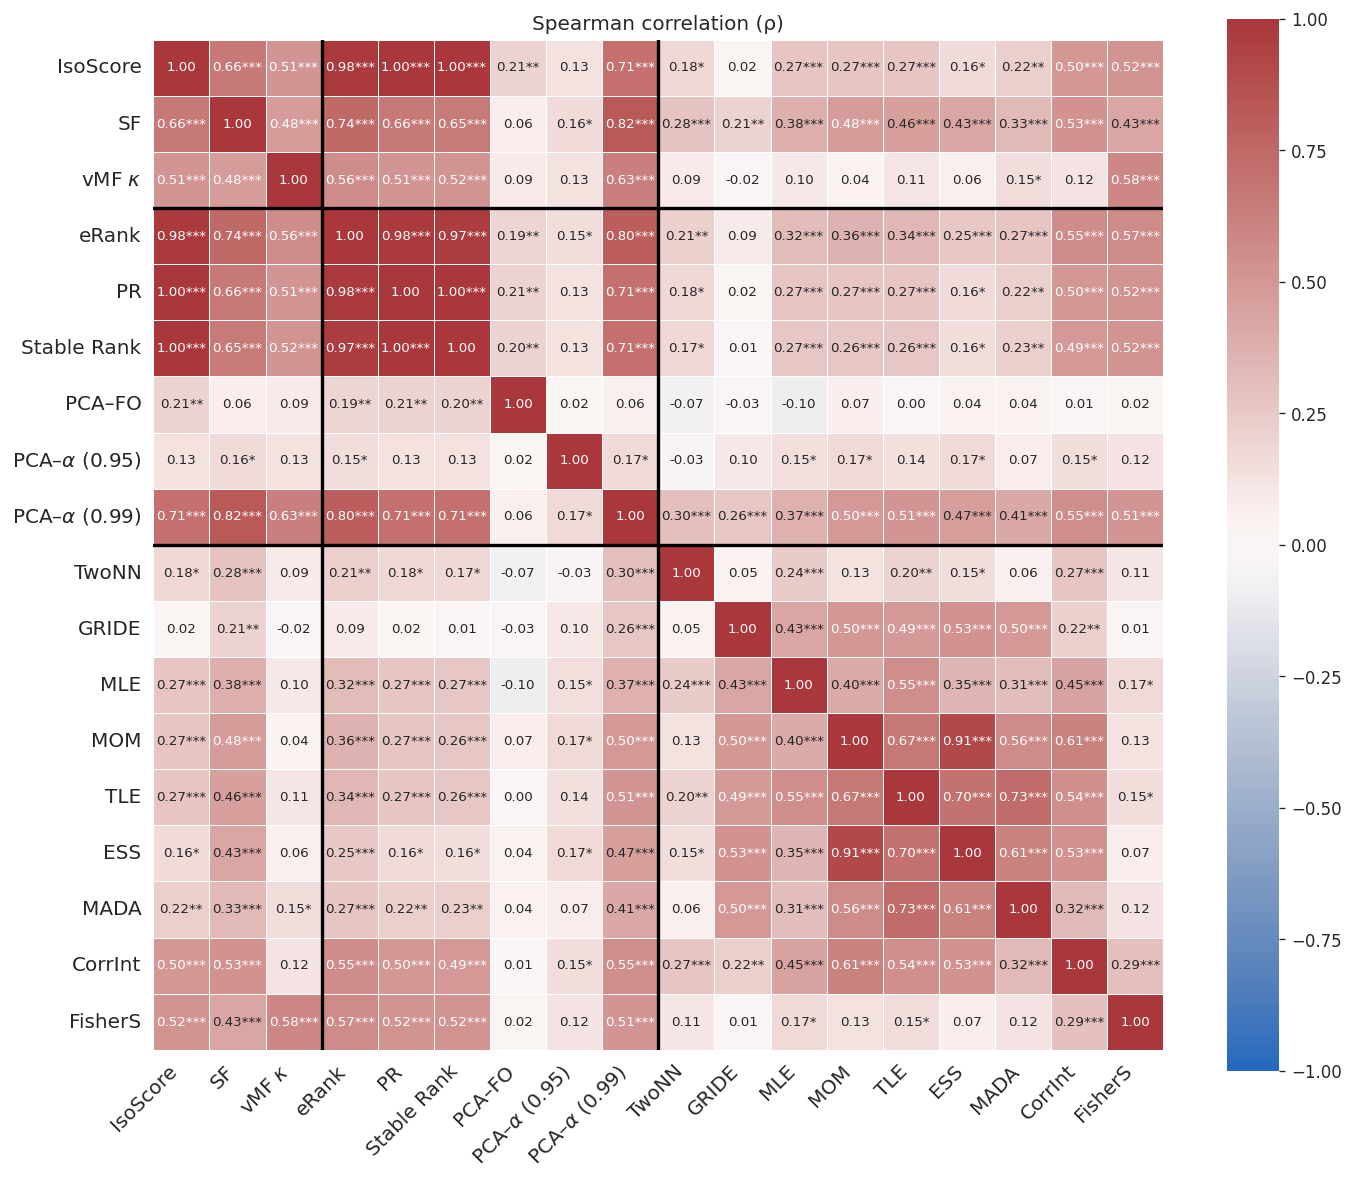

Saved heatmap: metric_corr_layer12_gpt/corr_heatmap_stars2.pdf


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    corr_plot,
    vmin=-1, vmax=1, center=0,
    cmap="vlag",
    square=True,
    annot=corr_star_plot,   # seaborn supports passing an array-like for annot 
    fmt="",                 # fmt ignored when annot is an array of strings
    annot_kws={"fontsize": 8},
    linewidths=0.5,
)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)


# Draw separators between families (Isotropy | Linear ID | Nonlinear ID)
iso_end = sum(m in metric_cols for m in ISO_METRICS)
lin_end = iso_end + sum(m in metric_cols for m in LIN_METRICS)

# positions are in "cell coordinates"
for cut in [iso_end, lin_end]:
    ax.axhline(cut, color="black", lw=2.0)
    ax.axvline(cut, color="black", lw=2.0)

title = f"Spearman correlation (ρ)"
plt.title(title)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

out_path = OUT_DIR / "corr_heatmap_stars2.pdf"
plt.savefig(out_path, dpi=220)
plt.show()

print("Saved heatmap:", out_path)
